In [1]:
#Meghna Sitaram 8/23/2023 
import numpy as np
import astropy.wcs as wcs
from astropy.wcs import WCS
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.pyplot as plt
from scipy.optimize import minimize

* <s>import files</s>
* <s>convert RA/DEC to pixels on detector</s>
* <s>make function to minimize (sum of diffs between points), parameters = offset, rotation, magnification</s>
* <s>move mask files to columbia computer</s>
* <s>set up masks as a class</s>
* <s>run for F1, F3, F4</s>
* make rotation + magnification around actual center 
* run for F2, QSO, QSOB

In [4]:
#mask holds information on targets, slits, and offset, rotation, magnification for each mask
class mask:
    
    def __init__(self, name, center_ra, center_dec, allow2rotate):
        
        #import relevant info from target and slit file 
        slits = pd.read_csv(name + '.csv')
        slits = slits[slits['line'] == 206]
        targets = pd.read_csv('targets_' + name + '.csv')
        slitpos = slits[['name', 'X_IMAGE', 'Y_IMAGE']]
        targetpos = targets[['Internal-count', 'RA', 'DEC']]
        targetpos = targetpos[np.abs(targetpos['RA'] - center_ra) < 2]
        targetpos = targetpos.rename(columns={"Internal-count": "name"})
        
        #combine rows matched by ID (name and Internal-count)
        self.df = pd.DataFrame.merge(slitpos, targetpos)
        
        #save RA, DEC and slit pos information matched up
        self.targetra = self.df['RA']
        self.targetdec = self.df['DEC']
        self.slitx = self.df['X_IMAGE']
        self.slity = self.df['Y_IMAGE']
                
        #should it calculate rotation for this mask in get_orm_coords
        self.allow2rotate = allow2rotate 
        
        #create WCS header 
        self.w = wcs.WCS(naxis=2)
        self.w.wcs.crpix = [1000, 1500]
        #self.w.wcs.cdelt = [ 1.08*1.027 / 3600, 1.26 *1.0063 / 3600] (first one tried)
        self.w.wcs.cdelt = [ 1.08*1.0240 / 3600, 1.26 *1.0049 / 3600]
        self.w.wcs.crval = [center_ra, center_dec]
        self.w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

        #convert to RA and Dec
        self.coords = SkyCoord(ra = self.targetra, dec = self.targetdec, unit='deg')
        target_px = skycoord_to_pixel(self.coords, self.w)
        self.target_px = [target_px[1], -1*target_px[0]]
        
        self.center_ra = center_ra
        self.center_dec = center_dec

        #find field center 
        self.px_center = skycoord_to_pixel(SkyCoord(ra = self.center_ra, dec = self.center_dec, unit='deg'), self.w)

        
            
    
    #make a first guess at the x and y offset to feed into the minimize function 
    #just uses the difference between the mean of target x,y and slit x,y
    def guess_offset(self):
        
        targetcen_x = np.nanmean(self.target_px[0])
        targetcen_y = np.nanmean(self.target_px[1])
        
        slitcen_x = np.mean(self.slitx)
        slitcen_y = np.mean(self.slity)
        
        offsetx = slitcen_x - targetcen_x
        offsety = slitcen_y - targetcen_y
        
        return offsetx, offsety 

    
        
        
        
    
    #input: original pixel coords and then offset in x and y, and magnification
    #output: translated and magnified pixel coordinates
    def get_orm_coords(self, offsetx, offsety, rotation, magnification):
        

        #add rotation to WCS
        if self.allow2rotate == True: 
            self.w.wcs.crota = [0.1, 0.1]
            target_px = skycoord_to_pixel(self.coords, self.w)
            print(target_px)
            self.target_px = [target_px[1], -1*target_px[0]]
            self.px_center = skycoord_to_pixel(SkyCoord(ra = self.center_ra, dec = self.center_dec, unit='deg'), self.w)
            
            
        target_px_r = np.array([self.target_px[0], self.target_px[1]])

        #apply offset 
        offset = np.array([offsetx, offsety])
        target_px_ro = np.array(target_px_r).T + offset


        #apply magnification 
        target_px_ro_delt = target_px_ro - self.px_center
        target_px_rom = (target_px_ro_delt * magnification) + self.px_center

        return target_px_rom
    
    
    
    
    #inputs: args = [offset in x, offset in y, rotation, magnification], and original pixel coordinates
    #outputs: sum of squares of difference between translated/rotated/magnified coordinates and slit positions
    def distance(self, args):    
        offsetx, offsety, rotation, magnification = args

        target_px_orm = self.get_orm_coords(offsetx, offsety, rotation, magnification)

        xoff = target_px_orm[:,0] - self.slitx
        yoff = target_px_orm[:,1] - self.slity

        return np.sum(xoff**2 + yoff**2)
    
    
    
    
        
    def find_magnification(self, x0, bounds):
        x = minimize(self.distance, x0, bounds=bounds)
        
        self.offsetx = x['x'][0]
        self.offsety = x['x'][1]
        self.rotation = x['x'][2]
        self.magnification = x['x'][3]
        
        matched_target_px = self.get_orm_coords(self.offsetx, self.offsety, self.rotation, self.magnification)
        
        return matched_target_px

Magnification: 1.0093217222207378


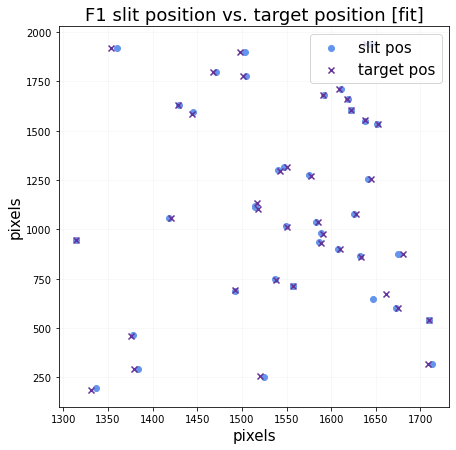

In [5]:
F1 = mask('F1', 32.19, -5.688, False)

offsetguessx, offsetguessy = F1.guess_offset()

F1_x0 = F1.get_orm_coords(offsetguessx, offsetguessy, 0, 1.01)

F1_matched = F1.find_magnification(np.array([offsetguessx, offsetguessy, 0, 1.0]), 
                                    [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
                                     [0, 0.1], [0.97, 1.3]])

plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(F1.slitx,F1.slity, label='slit pos', c='cornflowerblue')
plt.scatter(F1_matched[:,0], F1_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
#plt.scatter(F1_x0[:,0], F1_x0[:,1], label='target pos', c='red', marker='x')
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('F1 slit position vs. target position [fit]', fontsize=18)


print('Magnification:', F1.magnification)

(array([ 810.22573252,  647.32097243,  822.70291982,  850.46701453,
        813.29518306,  990.63890591,  821.27621123,  778.69093326,
       1185.19374439,  768.2487359 , 1229.92686072,  757.24924406,
       1053.60853368, 1040.62367862, 1332.05166049, 1262.40212542,
       1207.55217968, 1387.08034997]), array([2042.30610574, 1838.47824886, 1840.08639385, 1764.87682299,
       1687.9795636 , 1699.48550214, 1563.11315941, 1468.91123991,
       1326.59840235, 1079.87582516, 1172.94844977,  881.22128974,
        899.52037126,  850.09042811,  851.64686358, 1484.21169243,
       1544.55180345, 1124.58117613]))


Text(0.5, 1.0, 'F2 slit position vs. target position [fit]')

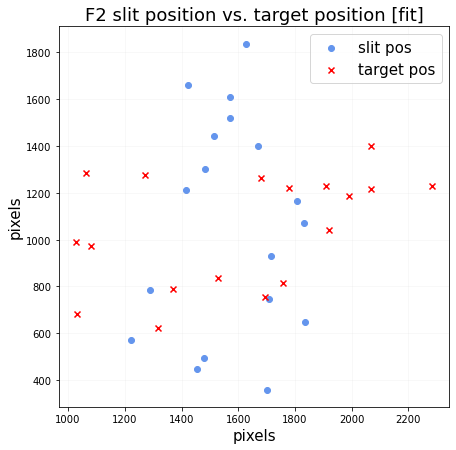

In [8]:
F2 = mask('F2', 253.0624, 34.9699, True)

offsetguessx, offsetguessy = F2.guess_offset()

F2_x0 = F2.get_orm_coords(offsetguessx, offsetguessy, 75, 1.05)

#F2_matched = F2.find_magnification(np.array([offsetguessx, offsetguessy, 70, 1.0]), 
#                                    [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
#                                     [65, 75], [0.9, 1.3]])

plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(F2.slitx,F2.slity, label='slit pos', c='cornflowerblue')
#plt.scatter(F2_matched[:,0], F2_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
plt.scatter(F2_x0[:,0], F2_x0[:,1], label='target pos', c='red', marker='x')
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('F2 slit position vs. target position [fit]', fontsize=18)


#print('Magnification:', F2.magnification)

In [7]:
#magnification guess 
F2_x0

array([[   76.42038224, -1079.55818075],
       [ -137.59886748,  -908.50818266],
       [ -135.91031525, -1092.65922742],
       [ -214.88036465, -1121.81152686],
       [ -295.62248701, -1082.78110381],
       [ -283.54125154, -1268.99201281],
       [ -426.7322114 , -1091.16118339],
       [ -525.64422688, -1046.44664153],
       [ -675.07270632, -1473.27459322],
       [ -934.13141237, -1035.4823343 ],
       [ -836.40515653, -1520.24436536],
       [-1142.71867456, -1023.93286787],
       [-1123.50463897, -1335.11012197],
       [-1175.40607927, -1321.47602415],
       [-1173.77182203, -1627.47540511],
       [ -509.57875174, -1554.3433933 ],
       [ -446.22163517, -1496.75095027],
       [ -887.19079385, -1685.25552908]])

Magnification: 1.0151069567371742


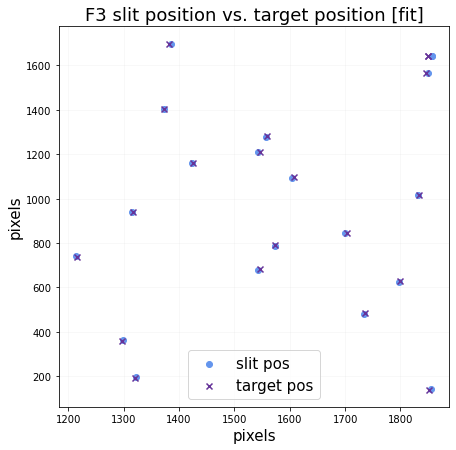

In [9]:
F3 = mask('F3', 352.3424, 0.21245, False)

offsetguessx, offsetguessy = F3.guess_offset()
F3_matched = F3.find_magnification(np.array([offsetguessx, offsetguessy, 0, 1.0]), 
                                           [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
                                           [0, 1], [0.97, 1.3]])
plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(F3.slitx, F3.slity, label='slit pos', c='cornflowerblue')
plt.scatter(F3_matched[:,0], F3_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('F3 slit position vs. target position [fit]', fontsize=18)

print('Magnification:', F3.magnification)

Magnification: 1.0173392898103801


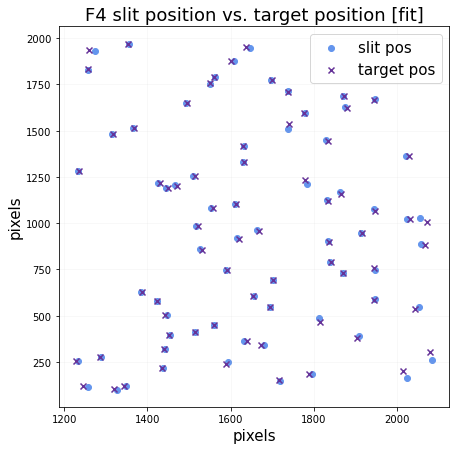

In [10]:
F4 = mask('F4', 36.9049, 0.65245, False)

offsetguessx, offsetguessy = F4.guess_offset()

F4_matched = F4.find_magnification(np.array([offsetguessx, offsetguessy, 0, 1.0]), 
                                           [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
                                           [0, 1], [0.97, 1.3]])
plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(F4.slitx, F4.slity, label='slit pos', c='cornflowerblue')
plt.scatter(F4_matched[:,0], F4_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
#plt.scatter(F4_x0[:,0], F4_x0[:,1])
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('F4 slit position vs. target position [fit]', fontsize=18)

print('Magnification:', F4.magnification)

155.3289176777787
1881.7574852630619
(array([1424.84091061,  511.32464216,  932.52219963,  584.95467086,
       1088.30258867, 1804.01712083]), array([1491.78760547, 1784.07230389, 1591.39224339, 1624.59520479,
       1426.02087476, 1622.83509481]))


Text(0.5, 1.0, 'QSO slit position vs. target position [fit]')

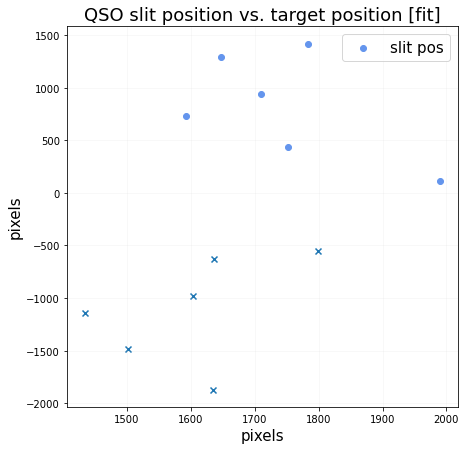

In [11]:
QSO = mask('QSO', 22.42638, 0.62279, True)

offsetguessx, offsetguessy = QSO.guess_offset()
print(offsetguessx)
print(offsetguessy)

QSO_x0 = QSO.get_orm_coords(0, 0, 0, 1.02)

#QSO_matched = QSO.find_magnification(np.array([offsetguessx, offsetguessy, 16, 1.02]), 
#                                             [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
#                                             [15, 25], [0.97, 1.3]])
plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(QSO.slitx, QSO.slity, label='slit pos', c='cornflowerblue')
#plt.scatter(QSO_matched[:,0], QSO_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
plt.scatter(QSO_x0[:,0], QSO_x0[:,1], marker='x')
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('QSO slit position vs. target position [fit]', fontsize=18)

#print('Magnification:', QSO.magnification)
#print('Angle: ', QSO.rotation)
#print('offsets:', QSO.offsetx, QSO.offsety)

In [1016]:
QSO.targetra

0    22.55721
1    22.27638
2    22.40590
3    22.29910
4    22.45386
5    22.67362
Name: RA, dtype: float64

157.132792508414 2028.537935228595 0.0 1.008513314415505


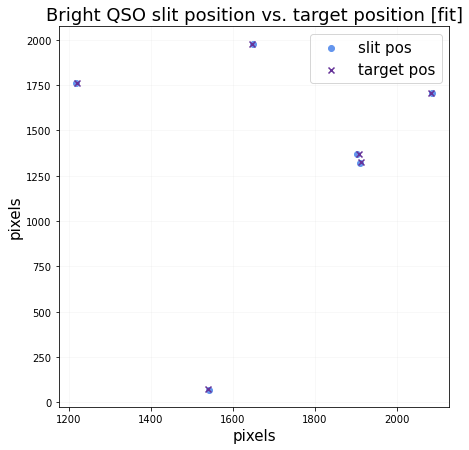

In [12]:
QSOb = mask('QSObright', 11.865604, 3.244401, False)

offsetguessx, offsetguessy = QSOb.guess_offset()

QSOb_x0 = QSOb.get_orm_coords(offsetguessx, offsetguessy, 0, 1.0)
#offsetguessx = -1900
#offsetguessy = -140

QSOb_matched = QSOb.find_magnification(np.array([offsetguessx, offsetguessy, 0, 1.0]), 
                                             [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
                                             [-2, 2], [0.95, 1.3]])
plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(QSOb.slitx, QSOb.slity, label='slit pos', c='cornflowerblue')
plt.scatter(QSOb_matched[:,0], QSOb_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
#plt.scatter(QSOb_x0[:,0], QSOb_x0[:,1], c='red', marker='x')
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('Bright QSO slit position vs. target position [fit]', fontsize=18)

print(QSOb.offsetx, QSOb.offsety, QSOb.rotation, QSOb.magnification)

In [805]:
QSOb.df

,name,X_IMAGE,Y_IMAGE,RA,DEC
0,0,1542.604385,71.176661,12.156605,3.201910
1,7,1902.657997,1372.657461,11.760525,3.329965
2,6,1909.857021,1321.395546,11.774661,3.331885
3,11,2084.245089,1705.097671,11.657906,3.391203
4,12,1218.130763,1760.635957,11.641300,3.090000
5,16,1649.689568,1979.070512,11.575089,3.238770


In [ ]:
#old rotation code:
#             rotation = np.deg2rad(rotation)
#             target_px_delt = np.array([self.target_px[0], self.target_px[1]]).T - self.px_center
#             cos_rot = np.cos(rotation)
#             sin_rot = np.sin(rotation)
#             R = np.array([[cos_rot, -1*sin_rot],
#                          [sin_rot,  cos_rot]])
#             target_px_r = (R @ target_px_delt.T).T + self.px_center

#else: #target_px_r = np.array([self.target_px[0], self.target_px[1]]).T